# Running a CV-Res Simulation [1]
### First, Importing required packages & libraries
**WNTR** for running EPANET simulations in Python  
**NUMPY & PANDAS** for data handling and processing  
**MatPlotLib** for plotting output  
**timeit** for execution time of EPANET simulation (To compare computational efficiency)  
**re** for searching and matching text in the .inp file using regular expressions

In [94]:
import wntr  
import numpy as np 
import pandas as pd
import matplotlib as mpl
from matplotlib import figure
import matplotlib.pyplot as plt
import timeit 
import re
import pathlib

### Specifying paths for simulation files and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute unless running the network files provided within the repo*  
Input filename (with extensions) as string.  
For running the .inp files in this repository, you can use this relative path `"../../Network-Files/Network X/"` where X is the network number 

In [95]:
 # Replace with appropriate path and filename
directory=pathlib.Path("../../Network-Files/Network 3")
filename=pathlib.Path("Network3_4hr_CV-Res.inp")
name_only=str(filename.stem)
print("Selected File: ",name_only)
path=directory/filename

Selected File:  Network3_4hr_CV-Res


### Parse Input File for Required Information
Some key input are needed for postprocessing purposes, and thus need to be extracted from the .inp file  
Such as:  
* Reservoir IDs to be excluded from nodes in FRW methods
* Supply duration for volume calculations in FRW and VRW methods
* Number of demand nodes  
 
First, we build the network model using WNTR's network module  
then we extract the needed data from the objects built by the network model

In [96]:
# create network model from input file
network = wntr.network.WaterNetworkModel(path)

demand_links=[]        #list of pipes connected to demand nodes only
lengths=[]
diameters=[]
hwcoeff=[]


for link in network.links():
    if re.search('^PipeforNode',link[1].name):
        demand_links.append(link[1].name)
        lengths.append(link[1].length)
        diameters.append(link[1].diameter)
        hwcoeff.append(link[1].roughness)
# Get the supply duration in seconds as an integer
supply_duration=int(network.options.time.duration/60)

### Determining Desired Demands in Res method
Unlike all other methods, the desired demand is not explicitly stated anywhere in the EPANET .inp file.  
In VRW methods, tank volumes represent desired demand volume, while in FRW methods demand flowrate is expressed in the demand node or the connected FCV  
for Unrestricted methods, the demand has to be calculated from the characteristics of the pipe connecting the node to the artificial reservoir
Backcalcualting the desired flow rate from the desired and minimum head, length, H-W coefficient and diameter

In [97]:
lengths=np.array(lengths)
diameters=np.array(diameters)
hwcoeff=np.array(hwcoeff)

desired_head=10
minimum_head=0
head_diff=desired_head-minimum_head
desired_demands=(head_diff/lengths*hwcoeff**1.852*diameters**4.8704/10.67)**0.54

### Running an EPANET simulation through WNTR


In [98]:
# run simulation
sim = wntr.sim.EpanetSimulator(network)
# store results of simulation
results=sim.run_sim()

### (OPTIONAL) Running a timed simulation 
for assessing computational efficiency. Requires a number of iterations to average timing over.

In [99]:
# # Specify number of iterations to time and average over (more= more confidence in mean time per run)
# n_iterations=1000

# # Statement to be timed: read filename, create network model, run network simulation
# timed_lines='inp_file='+"'"+path+"'"
# timed_lines=timed_lines+'''
# wn = wntr.network.WaterNetworkModel(inp_file) 
# wntr.sim.EpanetSimulator(wn)
# '''

# # Time and average over number of iterations
# time=np.round(timeit.timeit(stmt=timed_lines,setup='import wntr',number=n_iterations)/n_iterations*1000,decimals=2)
# print("Time taken for ",filename,' is ', time, 'milliseconds per run')

### Extracting and filtering the results

In [100]:
timesrs_demand=pd.DataFrame()
reporting_time_step=network.options.time.report_timestep
# timesrs_demand[0]=results.link['flowrate'].loc[0,:]
for i in range(0,supply_duration*60,reporting_time_step):
    # Extract Node Pressures from Results
    timesrs_demand=pd.concat([timesrs_demand,results.link['flowrate'].loc[i,:]],axis=1)

# Transpose DataFrame such that indices are time (sec) and Columns are each Node
timesrs_demand=timesrs_demand.T
# Filter DataFrame for Columns that contain Data for demand nodes only i.e., Tanks in STM
timesrs_demand=timesrs_demand.filter(demand_links)


### Calculating Desired Volumes
For FRW methods, volumes are not a direct output of the simulation, but instead are calculated based on demands withdrawn at all time steps  
This is not required for VRW methods 

In [101]:
# Calculates the total demand volume in the specified supply cycle
desired_volumes=[]

# Loop over each desired demand
for demand in desired_demands:
    # Append the corresponding desired volume (cum) = demand (LPS) *60 sec/min * supply duration (min) / 1000 (L/cum)
    desired_volumes.append(float(demand)*60*float(supply_duration))

# Combine demands (LPS) to their corresponding desired volume (cum)
desired_volumes=dict(zip(demand_links,desired_volumes))

# Initalized DataFrame for storing volumes received by each demand node as a timeseries
timesrs_satisfaction=pd.DataFrame(index=timesrs_demand.index,columns=desired_volumes.keys())
# Set Initial volume for all consumers at 0
timesrs_satisfaction.iloc[0,:]=0

# Loop over consumers and time steps to add up volumes as a percentage of total desired volume (Satisfaction Ratio)
for timestep in list(timesrs_satisfaction.index)[1:]:
    for node in timesrs_satisfaction.columns:
        # Cummulatively add the percent satisfaction ratio (SR) increased each time step
        ## SR at time t = SR at time t-1 + demand at time t-1 (cms) *60 seconds per time step/ Desired Demand Volume (cum)
        timesrs_satisfaction.at[timestep,node]=timesrs_satisfaction.at[timestep-reporting_time_step,node]+timesrs_demand.at[timestep-reporting_time_step,node]*reporting_time_step/desired_volumes[node]

### Calculating Consumer Satisfaction Statistics
To get a better grasp of how the demands were distributed among consumers, we calculate some descriptive stats at each time step  
**Mean Satisfaction** describes the average state throughout the network, only reaches 100 if all demands are satisfied  
**Low percentile, Median, and High Percentile** at each time step for a sense of the shape of the distribution (for equality considerations) with time  
Choose the low percentile number desired (e.g., 10<sup>th</sup> percentile) and the high percentile (e.g., 90<sup>th</sup> Percentile) by changing their respective values below 

In [102]:
# Intialize Series for storing statistics
mean=pd.Series(dtype='float64')
median=pd.Series(dtype='float64')
low_percentile=pd.Series(dtype='float64')
high_percentile=pd.Series(dtype='float64')

# Set the percentile values to be calculated
low_percent_val=10   # Range 0 to 100 ONLY
high_percent_val=90  # Range 0 to 100 ONLY

# Loop over each row (time step) in the results and calculate values of mean, median, low and high percentiles
for row in timesrs_satisfaction.index:
    mean.loc[row]=np.mean(timesrs_satisfaction.loc[row,:])*100
    low_percentile.loc[row]=np.percentile(timesrs_satisfaction.loc[row,:],low_percent_val)*100
    median.loc[row]=np.percentile(timesrs_satisfaction.loc[row,:],50)*100
    high_percentile.loc[row]=np.percentile(timesrs_satisfaction.loc[row,:],high_percent_val)*100

### (Optional) Save .csv files with  Results & Stats
Comment out any files you do not need, or skip this cell entirely if you don't want any files saved to your local device

In [103]:
# Saves Entire Results DataFrame as Filename_TimeSeries.csv in the same path
timesrs_satisfaction.to_csv(path.parent/(name_only+"_TimeSeries.csv"))

# Saves Mean Satisfaction with time as Filename_Means.csv in the same path
mean.to_csv(path.parent/(name_only+"_Means.csv"))

# Saves Median Satisfaction with time as Filename_Medians.csv in the same path
median.to_csv(path.parent/(name_only+"_Medians.csv"))

# Saves the specified low percentile (XX) values with time as Filename_XXthPercentile.csv in the same path
low_percentile.to_csv(path.parent/(name_only+"_"+str(low_percent_val)+"thPercentile.csv"))

# Saves the specified high percentile (YY) values with time as Filename_YYthPercentile.csv in the same path
high_percentile.to_csv(path.parent/(name_only+"_"+str(high_percent_val)+"thPercentile.csv"))

### Result Visualisation
First we plot the Mean satisfaction in the network with time

<function matplotlib.pyplot.show(close=None, block=None)>

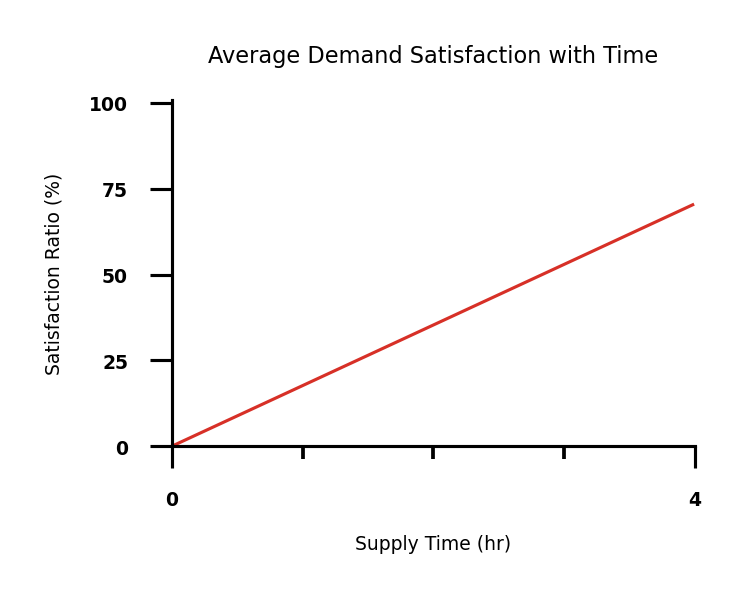

In [104]:
# Setting Universal Parameters for plotting style: dots per inch (dpi), text font and size, label size
mpl.rcParams['figure.dpi'] = 450
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 3}
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=3)
mpl.rcParams['axes.linewidth'] = 0.5

# Prepping an xaxis with hr format
supply_duration_hr=supply_duration/60
xaxis=np.arange(0,supply_duration_hr,1/60)

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Average Demand Satisfaction with Time')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)

# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,mean, c='#d73027',linewidth=0.5)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### Plotting the Distribution between Consumers (Equality)
Low Percentile, Median and High Percentile are plotted together to show the distribution between consumers with time. Area between Low and High Percentiles will be shaded

<function matplotlib.pyplot.show(close=None, block=None)>

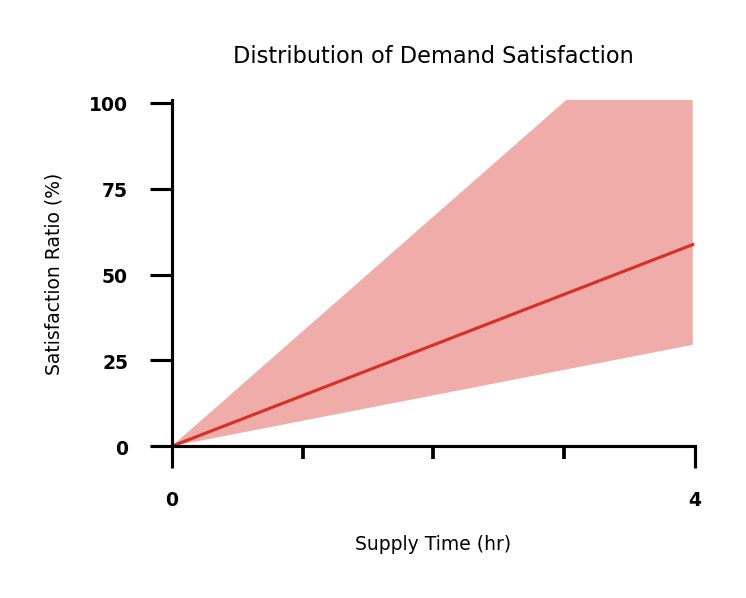

In [105]:
# Prepping an xaxis with hr format

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Distribution of Demand Satisfaction')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)


# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,median, c='#d73027',linewidth=0.5)
plt.fill_between(xaxis, y1=low_percentile, y2=high_percentile, alpha=0.4, color='#d73027', edgecolor=None)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### References:
##### [1] S. Mohapatra, A. Sargaonkar, and P. K. Labhasetwar, “Distribution Network Assessment using EPANET for Intermittent and Continuous Water Supply,” Water Resources Management, vol. 28, no. 11, pp. 3745–3759, Sep. 2014, doi: 10.1007/s11269-014-0707-y.